# Figure_4_ArgR

## Package, data, and function import

In [2]:
from pathlib import Path
import sys
import os.path

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import matplotlib.font_manager as fm

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', 50)

import json

from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
from scipy.cluster.hierarchy import linkage, leaves_list

import seaborn as sns
sns.set_style('whitegrid')

from tqdm.notebook import tqdm
from pymodulon.compare import compare_ica
from pymodulon.core import IcaData
from pymodulon.io import load_json_model, save_to_json
from pymodulon.plotting import *
from pymodulon.util import explained_variance
from pymodulon.imodulondb import imdb_gene_presence

import itertools

sys.path.append('../bitome2/')
sys.path.append('../')

from bitome.core import Bitome
from feature_functions import *

### Load the data from ./Data/ folder

In [3]:
precise1k = load_json_model('../Data/p1k.json.gz')

In [4]:
P1K_Gene_Presence_Matrix = pd.read_csv("../Data/P1K_Gene_Presence_Matrix.csv", index_col=0)

In [5]:
RegulonDB_TRN = pd.read_csv('../Data/RegulonDB_TRN_C_and_S.csv', index_col = 0)

In [6]:
Regulon_DB_P1K = pd.read_csv('../Data/Regulon_DB_P1K.csv', index_col=0)

In [7]:
biocyc_info = pd.read_csv('../Data/biocyc_info.txt', sep="\t")

In [8]:
iM_table = pd.read_csv('../Data/iM_table.csv', index_col = 0)

### PRECISE-1K: X M A log_tpm gene_presence_matrix

In [9]:
P1K_M = precise1k.M

In [10]:
P1K_A = precise1k.A

In [11]:
P1K_X = precise1k.X

In [12]:
P1K_log_tpm = precise1k.log_tpm

In [13]:
P1K_A

,p1k_00001,p1k_00002,p1k_00003,p1k_00004,p1k_00005,p1k_00006,p1k_00007,p1k_00008,p1k_00009,p1k_00010,p1k_00011,p1k_00012,p1k_00014,p1k_00015,p1k_00016,p1k_00017,p1k_00018,p1k_00019,p1k_00020,p1k_00021,p1k_00022,p1k_00023,p1k_00024,p1k_00025,p1k_00026,...,p1k_01031,p1k_01032,p1k_01033,p1k_01034,p1k_01035,p1k_01036,p1k_01037,p1k_01038,p1k_01039,p1k_01040,p1k_01041,p1k_01042,p1k_01043,p1k_01044,p1k_01045,p1k_01046,p1k_01047,p1k_01048,p1k_01049,p1k_01050,p1k_01051,p1k_01052,p1k_01053,p1k_01054,p1k_01055
Sugar Diacid,0.048851,-0.048851,2.226245,2.238391,0.222740,0.383348,1.534940,1.480178,0.536021,0.167563,1.288630,1.626597,1.258475,1.990426,1.846038,1.789221,1.938545,3.457002,2.887799,2.718241,2.600591,2.066270,2.207493,2.886696,2.855644,...,1.454841,0.405885,0.127749,2.664417,2.086622,1.940630,1.973620,1.563920,0.993799,0.322949,2.514396,2.429903,1.440703,1.453973,1.106521,0.605951,3.969272,3.960774,3.431303,3.198403,3.865406,1.095074,2.575524,1.850326,2.035736
Translation,0.201055,-0.201055,-8.162122,-8.046208,1.633678,1.973262,-8.058080,-6.272859,-1.536470,-1.828831,-2.220275,-2.539469,-0.561144,-1.515105,-1.510749,-2.689864,-2.368047,-8.877550,-8.803855,-8.780226,-8.639287,-4.195561,-4.998033,-9.561204,-9.245725,...,-4.966702,2.897288,1.894875,-3.425356,-3.272493,-4.273753,-4.360105,-4.558578,4.059448,3.632953,-4.063804,-6.635133,-2.217584,-3.265757,2.326838,2.416670,-1.187724,-1.626310,-1.492168,-0.436511,-1.004710,5.258995,-1.782148,-4.601815,-5.110518
ygdT,-0.382475,0.382475,0.066040,-0.898701,-0.556961,-1.523642,0.039413,0.002855,0.256867,-1.890067,-0.803215,-1.019425,-1.960863,-0.920450,-1.368831,-1.042959,-1.989939,-0.522095,-0.968985,-0.696673,0.238025,-1.036752,-2.503547,-2.707423,-1.483188,...,1.235724,-1.273101,0.617752,0.326830,-2.805789,-0.889021,-1.619864,0.225049,-0.992967,-3.007017,1.294285,-2.228891,-0.435061,-3.435750,0.539937,-1.885401,0.689130,1.997418,2.177559,1.459224,-3.110064,4.336594,0.626609,-0.166365,0.539555
OxyR,0.130714,-0.130714,0.232581,-0.135165,-0.140487,-0.435341,-0.788937,-1.333850,0.255054,0.464381,0.234773,0.040732,-0.782781,0.128668,0.167571,0.321378,0.044701,8.229646,8.382211,-0.288055,-0.319192,8.040544,7.568739,7.605785,7.593425,...,-4.097624,-1.979749,-2.115734,-3.108412,-2.048854,-3.098203,-3.189433,-3.201293,-2.796621,-2.052347,-2.018041,-2.264934,-3.529772,-3.105472,-2.639638,-2.743285,-2.888544,-2.341820,-2.498864,-2.931448,-2.693465,-1.690293,-3.056924,-3.575826,-2.316941
FlhDC-2,-0.329000,0.329000,-5.319409,-5.196873,-7.144849,-6.758991,-5.930140,-5.934485,-1.775148,-3.070194,-5.471003,-4.907313,-5.404904,-4.544754,-4.835331,-5.492261,-5.515043,-6.820104,-6.491970,-5.940373,-5.844072,-6.895756,-6.041890,-6.467087,-7.029721,...,20.274116,23.324611,23.028741,5.731000,4.232918,15.829542,15.955434,15.438915,-0.772303,-0.355805,-4.525472,11.528496,-1.531416,-1.720736,3.519872,4.303118,1.626655,2.701441,1.840211,2.703303,1.862170,10.399505,-4.285524,2.349262,3.101853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glyoxylate,0.344877,-0.344877,5.450515,5.444039,-0.641401,-0.472477,5.557743,5.070821,0.423674,0.559522,0.192255,-0.077680,-0.836273,0.126584,0.569942,0.142471,0.186656,5.502837,6.214424,4.309905,4.714682,6.723739,6.238863,6.402883,6.613213,...,2.241570,0.614548,0.719867,3.633590,3.343900,1.361826,2.578535,2.524615,1.758007,0.349975,4.439423,4.216883,3.536682,3.653288,1.956514,1.180854,2.036347,2.514846,2.469912,2.064530,2.645660,0.830452,4.243346,2.047711,2.828812
CCK-PGI Del,0.077106,-0.077106,-0.260639,0.163570,1.030188,1.220775,-0.049178,0.392918,1.611484,1.699807,0.266153,0.406511,1.107106,0.808417,0.414296,-0.094382,0.211667,-1.013015,-1.450618,-1.843390,-1.395640,0.160310,0.657533,-0.437041,-0.976818,...,-0.712459,-0.619319,-0.131078,-0.536856,-0.013980,1.293885,0.602405,-0.615454,-0.115446,-0.539883,-0.475304,0

### Other Functions

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from scipy.cluster.hierarchy import linkage, leaves_list
import matplotlib.font_manager as fm

def plot_regulon_corr_heatmap_with_clustering(regulator, regulon_df, expression_df, gene_list, matrix=True, figure_size=(5, 4), save_path=None):
    # Define custom font properties
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Find the genes in the regulon by the given regulator
    genes_in_regulon = regulon_df.index[regulon_df[regulator] == 1].tolist()
    
    # Union of genes_in_regulon and gene_list
    union_genes = list(set(genes_in_regulon).union(set(gene_list)))
    
    # Subset the expression DataFrame for these genes
    expression_subset = expression_df.loc[union_genes]
    
    # Create a correlation matrix of expression for these genes
    correlation_matrix = expression_subset.transpose().corr()
    
    # Calculate the average of correlation values
    avg_corr_value = correlation_matrix.values[np.triu_indices_from(correlation_matrix, k=1)].mean()

    # Perform hierarchical clustering on the rows
    linkage_matrix = linkage(correlation_matrix, method='average')
    dendrogram_order = leaves_list(linkage_matrix)
    clustered_corr_matrix = correlation_matrix.iloc[dendrogram_order, dendrogram_order]

    # Get the ordered list of genes after clustering
    clustered_genes = clustered_corr_matrix.index

    # Plot the correlation matrix as a heatmap with clustering
    plt.figure(figsize=figure_size)
    sns.heatmap(clustered_corr_matrix, annot=False, cmap='coolwarm', center=0, cbar=False)

    # Remove all ticks (both x and y)
    ax = plt.gca()
    #ax.set_xticks([])
    #ax.set_yticks([])

    # Set title with custom font
    # plt.title(f'Corr Heatmap for {regulator} - Avg Corr: {avg_corr_value:.3f}', fontproperties=font_prop)

    # Set x and y labels with custom font
    ax.set_xlabel("Genes", fontproperties=font_prop)
    ax.set_ylabel("Genes", fontproperties=font_prop)

    # Add category boxes at the diagonal
    def add_category_box(start_idx, end_idx, color):
        width = end_idx - start_idx + 1
        rect = Rectangle((start_idx, start_idx), width, width, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)

    current_category = None
    start_idx = 0
    category_genes = []

    for idx, gene in enumerate(clustered_genes):
        if gene in genes_in_regulon and gene in gene_list:
            category = 'Overlap'
            color = 'lightgreen'
        elif gene in genes_in_regulon:
            category = 'Regulons'
            color = 'black'
        elif gene in gene_list:
            category = 'iModulons'
            color = 'yellow'
        else:
            category = None
            color = 'black'

        if category != current_category:
            if current_category is not None:
                add_category_box(start_idx, idx - 1, current_category_color)
                # Print genes in the current category
                print(f"{current_category} genes from index {start_idx} to {idx - 1}:")
                print(category_genes)
                category_genes = []
            current_category = category
            current_category_color = color
            start_idx = idx

        category_genes.append(gene)

    if current_category is not None:
        add_category_box(start_idx, len(clustered_genes) - 1, current_category_color)
        # Print genes in the final category
        print(f"{current_category} genes from index {start_idx} to {len(clustered_genes) - 1}:")
        print(category_genes)

    # Create custom legend with custom font
    legend_elements = [
        Line2D([0], [0], color='black', lw=2, label='Regulons'),
        Line2D([0], [0], color='yellow', lw=2, label='iModulons'),
        Line2D([0], [0], color='lightgreen', lw=2, label='Overlap of iModulons and Regulons')
    ]
    plt.legend(handles=legend_elements, loc='upper right', prop=font_prop)

    # Save the plot as an SVG file if save_path is provided
    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight')

    # Show the plot
    plt.show()

    if not matrix:
        clustered_corr_matrix = None

    return clustered_corr_matrix


In [16]:
# Add category boxes at the diagonal
def add_category_box(start_idx, end_idx, color):
    width = end_idx - start_idx + 1
    rect = Rectangle((start_idx, start_idx), width, width, fill=False, edgecolor=color, linewidth=2)
    ax.add_patch(rect)

    current_category = None
    start_idx = 0
    category_genes = []

    for idx, gene in enumerate(clustered_genes):
        if gene in genes_in_regulon and gene in gene_list:
            category = 'Overlap'
            color = 'lightgreen'
        elif gene in genes_in_regulon:
            category = 'Regulons'
            color = 'black'
        elif gene in gene_list:
            category = 'iModulons'
            color = 'yellow'
        else:
            category = None
            color = 'black'

        if category != current_category:
            if current_category is not None:
                add_category_box(start_idx, idx - 1, current_category_color)
                # Print genes in the current category
                print(f"{current_category} genes from index {start_idx} to {idx - 1}:")
                print(category_genes)
                category_genes = []
            current_category = category
            current_category_color = color
            start_idx = idx

        category_genes.append(gene)

    if current_category is not None:
        add_category_box(start_idx, len(clustered_genes) - 1, current_category_color)
        # Print genes in the final category
        print(f"{current_category} genes from index {start_idx} to {len(clustered_genes) - 1}:")
        print(category_genes)

    # Create custom legend with custom font
    legend_elements = [
        Line2D([0], [0], color='black', lw=2, label='Regulons'),
        Line2D([0], [0], color='yellow', lw=2, label='iModulons'),
        Line2D([0], [0], color='lightgreen', lw=2, label='Overlap of iModulons and Regulons')
    ]
    plt.legend(handles=legend_elements, loc='upper right', prop=font_prop)

    # Save the plot as an SVG file if save_path is provided
    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight')

    # Show the plot
    plt.show()

    if not matrix:
        clustered_corr_matrix = None

    return clustered_corr_matrix

In [17]:
def map_accession_to_gene_name(df, biocyc_info):

    # Reset index if 'Accession-1' is the index, and rename the column
    if df.index.name == 'Accession' or df.index.name is None:
        df = df.reset_index()
        df.rename(columns={'index': 'Accession'}, inplace=True)
        
    # Merge with biocyc_info to map 'Accession-1' to 'Gene Name'
    merged_df = df.merge(biocyc_info[['Accession', 'Gene Name']], on='Accession', how='left')

    # Set 'Gene Name' as the new index and drop the 'Accession-1' column
    merged_df.set_index('Gene Name', inplace=True)
    merged_df.drop(columns=['Accession'], inplace=True)

    # Remove rows with NaN as index
    merged_df = merged_df[merged_df.index.notna()]
    
    return merged_df

In [18]:
def get_genes_for_iM(df, regulator):

    if regulator not in df.columns:
        raise ValueError(f"Regulator '{regulator}' not found in DataFrame columns.")
    
    # Get the list of genes where the value in the specified column is 1
    genes_in_regulon = df.index[df[regulator] == 1].tolist()
    
    return genes_in_regulon

## Overview of ArgR

### The ArgR Regulon from RegulonDB

In [19]:
RegulonDB_TRN

,FecI,FliA,RpoD,RpoE,RpoH,RpoN,RpoS,AcrR,Ada,AdiY,AgaR,AidB,AlaS,AllR,AraC,ArcA,ArcZ,ArgP,ArgR,ArrS,ArsR,AscG,AtoC,BaeR,BasR,...,TreR,TrpR,TyrR,UhpA,UhpU,UlaR,UvrY,UxuR,XylR,XynR,YciT,YcjW,YdeO,YdfH,YebK,YefM,YefMB,YgiV,YhaJ,YiaU,YjjQ,YqhC,ZntR,ZraR,Zur
aaeA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaeB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaeR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaeX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abgA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
znuC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
zraP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
zraR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
zraS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [272]:
len(RegulonDB_TRN.index[RegulonDB_TRN['ArgR']==1].to_list())

64

### Figure - Expression correlation heatmap showing Regulon vs iModulon

In [21]:
P1K_log_tpm_gene_name = map_accession_to_gene_name(P1K_log_tpm, biocyc_info)

In [22]:
P1K_Gene_Presence_Matrix_gene_name = map_accession_to_gene_name(P1K_Gene_Presence_Matrix, biocyc_info)

In [23]:
Regulon_DB_TRN_filtered = RegulonDB_TRN.loc[RegulonDB_TRN.index.intersection(P1K_log_tpm_gene_name.index)]

In [24]:
ArgR_iM_Genes = get_genes_for_iM(P1K_Gene_Presence_Matrix_gene_name, 'Arginine')

In [270]:
len(ArgR_iM_Genes)

24

Overlap genes from index 0 to 1:
['artJ', 'argF']
iModulons genes from index 2 to 2:
['xynR']
Overlap genes from index 3 to 6:
['hisJ', 'hisQ', 'hisM', 'hisP']
Regulons genes from index 7 to 7:
['potF']
Overlap genes from index 8 to 11:
['artM', 'artI', 'artP', 'artQ']
Regulons genes from index 12 to 16:
['yraQ', 'waaA', 'stpA', 'argR', 'gltF']
Overlap genes from index 17 to 17:
['argE']
iModulons genes from index 18 to 18:
['dtpD']
Overlap genes from index 19 to 27:
['argD', 'argI', 'argA', 'argH', 'argG', 'argC', 'argB', 'carA', 'carB']
Regulons genes from index 28 to 45:
['lysO', 'cvpA', 'gltD', 'gltB', 'aroP', 'lrp', 'eutS', 'astE', 'astB', 'astD', 'astA', 'astC', 'ykgA', 'dacC', 'hchA', 'dps', 'ftsZ', 'pfkB']
iModulons genes from index 46 to 46:
['caiF']
Regulons genes from index 47 to 63:
['yffB', 'pyrL', 'puuB', 'yaaU', 'mukE', 'aroK', 'rpsO', 'ydgI', 'rimP', 'pnp', 'nusA', 'infB', 'rbfA', 'truB', 'yfcC', 'yhcC', 'gltP']
iModulons genes from index 64 to 64:
['asnA']


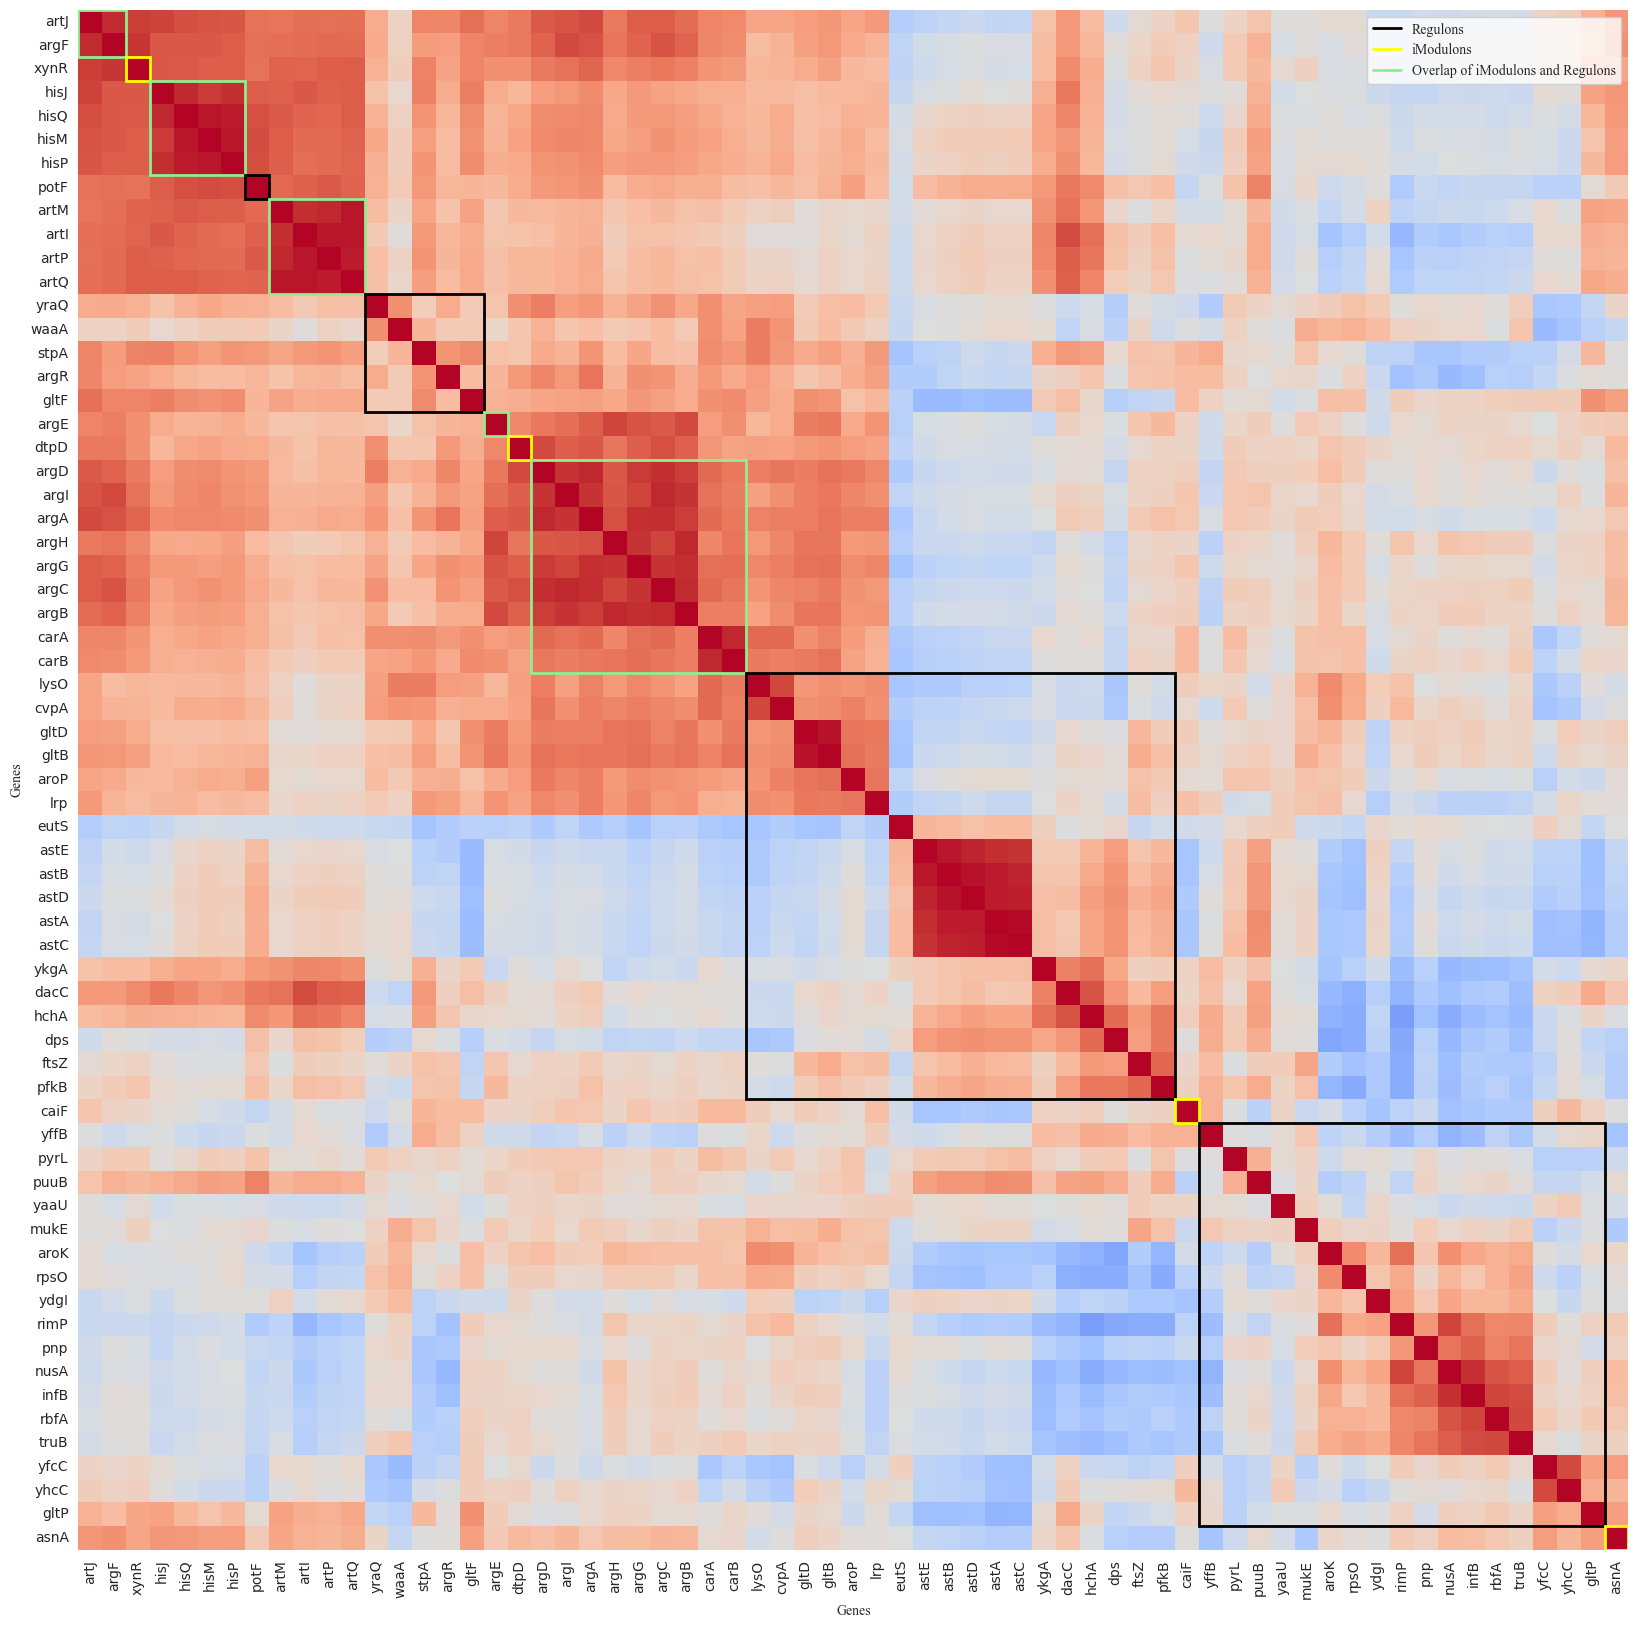

In [25]:
plot_regulon_corr_heatmap_with_clustering('ArgR', Regulon_DB_TRN_filtered, P1K_log_tpm_gene_name, ArgR_iM_Genes, matrix = False, figure_size = (20,20), save_path='ArgR_corr_heatmap.svg')

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from scipy.cluster.hierarchy import linkage, leaves_list
import matplotlib.font_manager as fm

def plot_regulon_corr_heatmap_with_clustering_and_correlation_columns(
    regulator, regulon_df, expression_df, gene_list, P1K_A, row1, row2, matrix=True, figure_size=(5, 4), save_path=None
):
    # Define custom font properties
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Find the genes in the regulon by the given regulator
    genes_in_regulon = regulon_df.index[regulon_df[regulator] == 1].tolist()
    
    # Union of genes_in_regulon and gene_list
    union_genes = list(set(genes_in_regulon).union(set(gene_list)))
    
    # Subset the expression DataFrame for these genes
    expression_subset = expression_df.loc[union_genes]
    
    # Create a correlation matrix of expression for these genes
    correlation_matrix = expression_subset.transpose().corr()
    
    # Calculate the average of correlation values
    avg_corr_value = correlation_matrix.values[np.triu_indices_from(correlation_matrix, k=1)].mean()

    # Perform hierarchical clustering on the rows
    linkage_matrix = linkage(correlation_matrix, method='average')
    dendrogram_order = leaves_list(linkage_matrix)
    clustered_corr_matrix = correlation_matrix.iloc[dendrogram_order, dendrogram_order]

    # Get the ordered list of genes after clustering
    clustered_genes = clustered_corr_matrix.index

    # Calculate correlations of each gene's expression with the specified rows from P1K_A
    corr_row1 = expression_subset.apply(lambda x: x.corr(P1K_A.loc[row1]), axis=1).reindex(clustered_genes)
    corr_row2 = expression_subset.apply(lambda x: x.corr(P1K_A.loc[row2]), axis=1).reindex(clustered_genes)

    # Plot the correlation matrix as a heatmap with clustering
    plt.figure(figsize=(figure_size[0] + 2, figure_size[1]))  # Adjust figure size for extra columns
    ax = sns.heatmap(clustered_corr_matrix, annot=False, cmap='coolwarm', center=0, cbar=False)

    # Add category boxes at the diagonal
    def add_category_box(start_idx, end_idx, color):
        width = end_idx - start_idx + 1
        rect = Rectangle((start_idx, start_idx), width, width, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)

    current_category = None
    start_idx = 0
    category_genes = []

    for idx, gene in enumerate(clustered_genes):
        if gene in genes_in_regulon and gene in gene_list:
            category = 'Overlap'
            color = 'lightgreen'
        elif gene in genes_in_regulon:
            category = 'Regulons'
            color = 'black'
        elif gene in gene_list:
            category = 'iModulons'
            color = 'yellow'
        else:
            category = None
            color = 'black'

        if category != current_category:
            if current_category is not None:
                add_category_box(start_idx, idx - 1, current_category_color)
                category_genes = []
            current_category = category
            current_category_color = color
            start_idx = idx

        category_genes.append(gene)

    if current_category is not None:
        add_category_box(start_idx, len(clustered_genes) - 1, current_category_color)

    # Plot additional columns for correlations using a shared y-axis
    corr_colors = sns.color_palette('coolwarm', as_cmap=True)
    
    # Add first correlation column
    ax_corr1 = plt.gca().inset_axes([1.01, 0, 0.02, 1], transform=ax.transAxes)
    sns.heatmap(pd.DataFrame(corr_row1).reindex(clustered_genes), ax=ax_corr1, cmap=corr_colors, cbar=False, yticklabels=False)
    ax_corr1.set_xticks([])
    ax_corr1.set_yticks(ax.get_yticks())  # Match y-axis ticks with the main plot
    ax_corr1.set_ylabel(row1, rotation=270, labelpad=10, fontproperties=font_prop)

    # Add second correlation column
    ax_corr2 = plt.gca().inset_axes([1.04, 0, 0.02, 1], transform=ax.transAxes)
    sns.heatmap(pd.DataFrame(corr_row2).reindex(clustered_genes), ax=ax_corr2, cmap=corr_colors, cbar=False, yticklabels=False)
    ax_corr2.set_xticks([])
    ax_corr2.set_yticks(ax.get_yticks())  # Match y-axis ticks with the main plot
    ax_corr2.set_ylabel(row2, rotation=270, labelpad=10, fontproperties=font_prop)

    # Create custom legend with custom font
    legend_elements = [
        Line2D([0], [0], color='black', lw=2, label='Regulons'),
        Line2D([0], [0], color='yellow', lw=2, label='iModulons'),
        Line2D([0], [0], color='lightgreen', lw=2, label='Overlap of iModulons and Regulons')
    ]
    plt.legend(handles=legend_elements, loc='upper right', prop=font_prop)

    # Save the plot as an SVG file if save_path is provided
    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight')

    # Show the plot
    plt.show()

    if not matrix:
        clustered_corr_matrix = None

    return clustered_corr_matrix


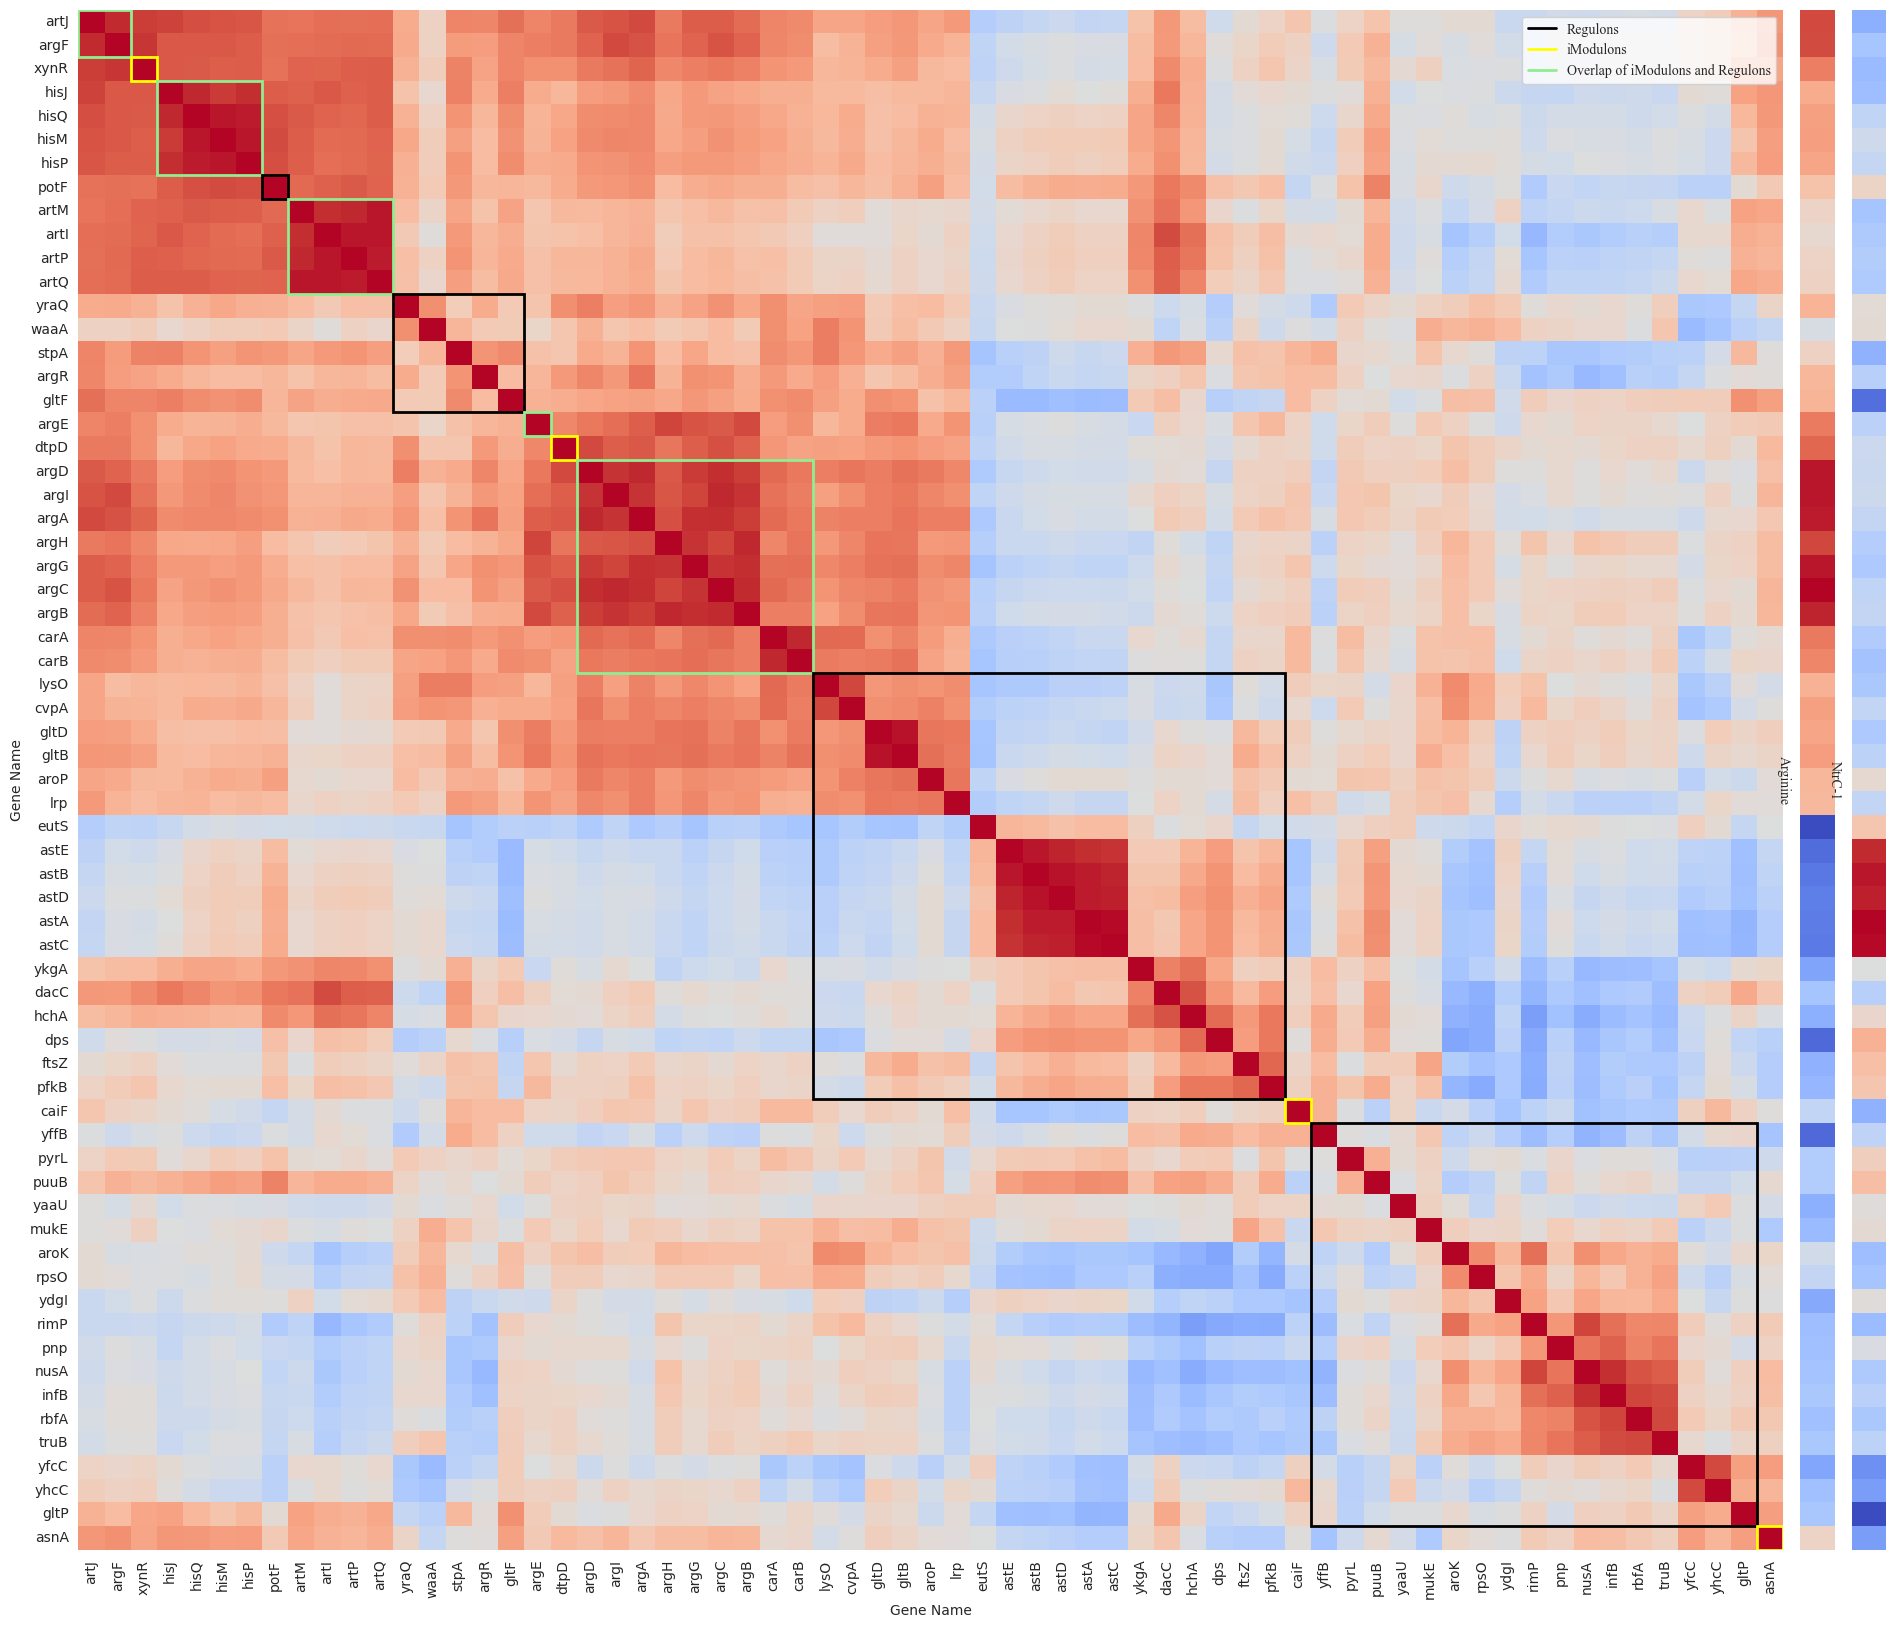

In [39]:
plot_regulon_corr_heatmap_with_clustering_and_correlation_columns(
    regulator='ArgR',
    regulon_df=Regulon_DB_TRN_filtered,
    expression_df=P1K_log_tpm_gene_name,
    gene_list=ArgR_iM_Genes,
    P1K_A=P1K_A,
    row1='Arginine',
    row2='NtrC-1', 
    matrix = False, 
    figure_size = (20,20), 
    save_path='ArgR_corr_heatmap.svg'
)

In [177]:
def plot_regulon_corr_heatmap_with_clustering_and_correlation_columns(
    regulator, regulon_df, expression_df, gene_list, P1K_A, row1, row2, row3, row4, row5, row6, row7,
    matrix=True, figure_size=(5, 4), save_path=None
):
    # Define custom font properties
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Find the genes in the regulon by the given regulator
    genes_in_regulon = regulon_df.index[regulon_df[regulator] == 1].tolist()
    
    # Union of genes_in_regulon and gene_list
    union_genes = list(set(genes_in_regulon).union(set(gene_list)))
    
    # Subset the expression DataFrame for these genes
    expression_subset = expression_df.loc[union_genes]
    
    # Create a correlation matrix of expression for these genes
    correlation_matrix = expression_subset.transpose().corr()
    
    # Calculate the average of correlation values
    avg_corr_value = correlation_matrix.values[np.triu_indices_from(correlation_matrix, k=1)].mean()

    # Perform hierarchical clustering on the rows
    linkage_matrix = linkage(correlation_matrix, method='average')
    dendrogram_order = leaves_list(linkage_matrix)
    clustered_corr_matrix = correlation_matrix.iloc[dendrogram_order, dendrogram_order]

    # Get the ordered list of genes after clustering
    clustered_genes = clustered_corr_matrix.index

    # Calculate correlations of each gene's expression with the specified rows from P1K_A
    rows = [row1, row2, row3, row4, row5, row6, row7]
    correlations = [expression_subset.apply(lambda x: x.corr(P1K_A.loc[row]), axis=1).reindex(clustered_genes) for row in rows]

    # Plot the correlation matrix as a heatmap with clustering
    plt.figure(figsize=(figure_size[0] + 6, figure_size[1]))  # Adjust figure size for extra columns
    ax = sns.heatmap(clustered_corr_matrix, annot=False, cmap='coolwarm', center=0, cbar=False)
    ax.set_xticks([])
    ax.set_xticklabels([])  # Remove x-axis tick labels
    ax.set_yticks([])
    ax.set_yticklabels([])  # Remove y-axis tick labels
    ax.set_xlabel("")  # Remove x-axis label
    ax.set_ylabel("")  # Remove y-axis label
    ax.set_aspect('equal')  # Ensure the heatmap is square

    # Add category boxes at the diagonal
    def add_category_box(start_idx, end_idx, color):
        width = end_idx - start_idx + 1
        rect = Rectangle((start_idx, start_idx), width, width, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)

    current_category = None
    start_idx = 0
    category_genes = []

    for idx, gene in enumerate(clustered_genes):
        if gene in genes_in_regulon and gene in gene_list:
            category = 'Overlap'
            color = 'lightgreen'
        elif gene in genes_in_regulon:
            category = 'Regulons'
            color = 'black'
        elif gene in gene_list:
            category = 'iModulons'
            color = 'yellow'
        else:
            category = None
            color = 'black'

        if category != current_category:
            if current_category is not None:
                add_category_box(start_idx, idx - 1, current_category_color)
                category_genes = []
            current_category = category
            current_category_color = color
            start_idx = idx

        category_genes.append(gene)

    if current_category is not None:
        add_category_box(start_idx, len(clustered_genes) - 1, current_category_color)

    # Plot additional columns for correlations using a shared y-axis
    corr_colors = sns.color_palette('coolwarm', as_cmap=True)
    
    # Add correlation columns with double width and triple the gap
    x_pos = 1.035
    increment = 0.08  # Triple the previous gap (assuming the previous was 0.03)
    
    for corr, label in zip(correlations, rows):
        ax_corr = plt.gca().inset_axes([x_pos, 0, 0.05, 1], transform=ax.transAxes)  # Double the width to 0.04
        sns.heatmap(pd.DataFrame(corr).reindex(clustered_genes), ax=ax_corr, cmap=corr_colors, cbar=False)
        ax_corr.set_xticks([])
        ax_corr.set_xticklabels([])  # Remove x-axis tick labels
        ax_corr.set_yticks([])  # Remove y-axis ticks
        ax_corr.set_yticklabels([])  # Remove y-axis tick labels
        ax_corr.axis('off')
        
        # Place the label at the bottom of the column
        ax_corr.text(
            1, -0.01, label, ha='right', va='top', rotation=60,
            fontproperties=font_prop, fontsize=10, transform=ax_corr.transAxes
        )
        
        x_pos += increment

    # Create custom legend with custom font
    legend_elements = [
        Line2D([0], [0], color='black', lw=2, label='Regulons'),
        Line2D([0], [0], color='yellow', lw=2, label='iModulons'),
        Line2D([0], [0], color='lightgreen', lw=2, label='Overlap of iModulons and Regulons')
    ]
    plt.legend(handles=legend_elements, loc='upper right', prop=font_prop, fontsize=10)

    # Save the plot as an SVG file if save_path is provided
    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight')

    # Show the plot
    plt.show()

    if not matrix:
        clustered_corr_matrix = None

    return clustered_corr_matrix

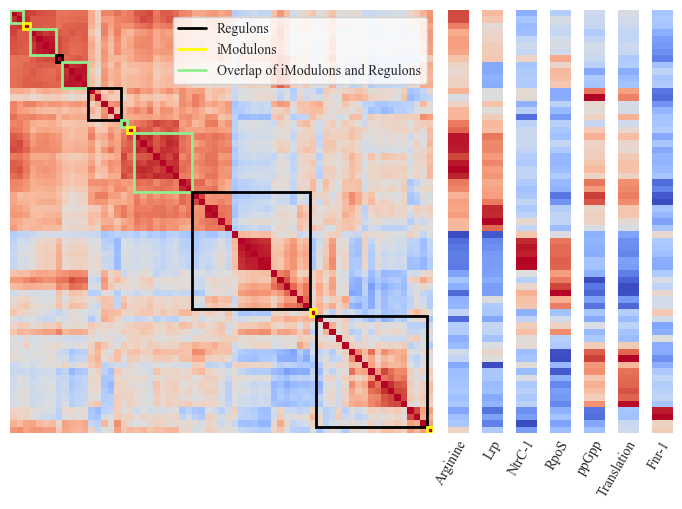

In [178]:
plot_regulon_corr_heatmap_with_clustering_and_correlation_columns(
    regulator='ArgR',
    regulon_df=Regulon_DB_TRN_filtered,
    expression_df=P1K_log_tpm_gene_name,
    gene_list=ArgR_iM_Genes,
    P1K_A=P1K_A,
    row1='Arginine',
    row2='Lrp',
    row3='NtrC-1',
    row4='RpoS',
    row5='ppGpp',
    row6='Translation',
    row7='Fnr-1',
    matrix = False, 
    figure_size = (9,5.5), 
    save_path='ArgR_corr_heatmap.svg'
)

In [190]:
def save_custom_colorbar(cmap, save_path="limited_colorbar.svg", orientation="horizontal", font_path='/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf', width=4, height=5.5):
    import matplotlib.pyplot as plt
    from matplotlib.colorbar import ColorbarBase
    from matplotlib.colors import Normalize
    import matplotlib.font_manager as fm

    # Load custom font properties
    font_prop = fm.FontProperties(fname=font_path)

    # Create a figure for the colorbar
    plt.figure(figsize=(width, height / 5.5))  # Adjusting height to maintain proportion with provided heatmap size

    # Create a ColorbarBase instance
    norm = Normalize(vmin=-1, vmax=1)  # Assuming the color range is between -1 and 1 for correlation values
    colorbar = ColorbarBase(plt.gca(), cmap=cmap, norm=norm, orientation=orientation)

    # Customizing ticks to show only -1, 0, and 1
    colorbar.set_ticks([-1, 0, 1])
    colorbar.set_ticklabels(['-1', '0', '1'])

    # Customizing font properties for ticks
    plt.gca().tick_params(axis='x', labelsize=10)
    for label in plt.gca().get_xticklabels():
        label.set_fontproperties(font_prop)

    # Save the colorbar to a file
    plt.savefig(save_path, format='svg', bbox_inches='tight')

    # Show the colorbar
    plt.show()

# Example usage with the colormap 'coolwarm'
# save_limited_colorbar(plt.cm.coolwarm, save_path="limited_colorbar.svg", orientation="horizontal", width=4, height=5.5)



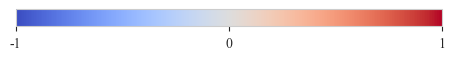

In [191]:
save_custom_colorbar(plt.cm.coolwarm, save_path="custom_colorbar.svg", orientation="horizontal", width=5.5, height=1.2)

In [197]:
def map_accession_to_gene_name(df, biocyc_info):

    # Reset index if 'Accession' is the index, and rename the column
    if df.index.name == 'Accession' or df.index.name is None:
        df = df.reset_index()
        df.rename(columns={'index': 'Accession'}, inplace=True)
        
    # Merge with biocyc_info to map 'Accession' to 'Gene Name'
    merged_df = df.merge(biocyc_info[['Accession', 'Gene Name']], on='Accession', how='left')

    # Identify rows with NaN 'Gene Name'
    removed_indices = merged_df[merged_df['Gene Name'].isna()]['Accession'].tolist()

    # Print the original indices that were removed
    print("Original indices removed due to NaN 'Gene Name':", removed_indices)

    # Set 'Gene Name' as the new index and drop the 'Accession' column
    merged_df.set_index('Gene Name', inplace=True)
    merged_df.drop(columns=['Accession'], inplace=True)

    # Remove rows with NaN as index
    merged_df = merged_df[merged_df.index.notna()]
    
    return merged_df

In [198]:
P1K_M = map_accession_to_gene_name(P1K_M, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [199]:
P1K_X = map_accession_to_gene_name(P1K_X, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [200]:
P1K_log_tpm = map_accession_to_gene_name(P1K_log_tpm, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [201]:
P1K_Gene_Presence_Matrix = map_accession_to_gene_name(P1K_Gene_Presence_Matrix, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [202]:
P1K_log_tpm

,p1k_00001,p1k_00002,p1k_00003,p1k_00004,p1k_00005,p1k_00006,p1k_00007,p1k_00008,p1k_00009,p1k_00010,p1k_00011,p1k_00012,p1k_00014,p1k_00015,p1k_00016,p1k_00017,p1k_00018,p1k_00019,p1k_00020,p1k_00021,p1k_00022,p1k_00023,p1k_00024,p1k_00025,p1k_00026,...,p1k_01031,p1k_01032,p1k_01033,p1k_01034,p1k_01035,p1k_01036,p1k_01037,p1k_01038,p1k_01039,p1k_01040,p1k_01041,p1k_01042,p1k_01043,p1k_01044,p1k_01045,p1k_01046,p1k_01047,p1k_01048,p1k_01049,p1k_01050,p1k_01051,p1k_01052,p1k_01053,p1k_01054,p1k_01055
Gene Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
thrA,10.260569,10.368555,11.193605,11.404163,10.497016,10.235690,9.477470,9.811860,10.735874,10.726916,10.359335,10.371057,10.248326,10.308245,10.291981,10.549571,10.621371,7.339912,7.349313,8.444351,8.361514,7.460928,7.465814,7.212381,7.256573,...,8.142084,9.509579,9.414470,8.253743,7.949339,8.337325,8.454997,8.365735,9.676087,9.581661,7.744039,7.414406,8.533118,8.600020,9.377806,9.446533,8.302502,8.452109,8.363976,8.672402,8.647693,9.675175,8.761815,8.421964,8.483203
thrB,9.920277,10.044224,11.045580,11.460140,10.374823,10.216922,9.219235,9.861262,10.528432,10.503092,10.361474,10.419787,10.517741,10.362353,10.381631,10.507449,10.569802,7.834760,7.870209,8.732210,8.715241,7.999095,7.921019,8.023161,7.969324,...,7.342121,8.628401,8.586056,7.474633,7.385777,7.777433,7.565013,7.359967,8.764157,8.462585,6.597643,6.986275,7.312223,7.516966,8.605460,8.480662,7.449754,7.467061,7.538769,7.723832,7.670143,8.857956,7.922229,7.633727,7.859478
thrC,9.936694,10.010638,9.976798,10.330368,9.876910,9.638754,8.258753,8.650959,9.739519,9.722997,9.749216,9.682084,9.770396,9.610242,9.689411,9.911410,9.890739,7.041015,7.156328,8.039599,8.038333,7.150819,7.074354,7.087950,7.073477,...,8.282155,9.437908,9.313148,8.329617,7.729902,8.250125,8.361819,8.353799,9.504832,9.473705,7.158008,7.580987,8.363932,8.500818,9.239408,9.282031,8.281564,8.364711,8.249902,8.597246,8.722178,9.444481,8.395833,8.590145,8.446588
yaaX,7.027515,7.237449,6.014337,5.854519,6.950936,6.768425,5.011006,5.137711,6.745798,6.497823,6.096755,6.224320,6.102888,5.881665,6.154649,6.063364,6.321053,4.546350,4.284352,4.650811,5.150531,4.528597,4.670083,4.038682,4.497817,...,1.874958,4.685518,4.504307,2.616101,4.072545,3.348901,3.427421,3.450931,4.489273,4.945451,2.841976,3.371937,1.680304,2.869023,4.681906,4.206849,2.505517,3.065065,4.168111,4.056920,4.030515,4.921936,3.311463,2.568554,4.185822
yaaA,6.537183,6.452699,6.371349,6.387164,6.321764,6.405053,6.286808,6.491897,6.460234,6.467135,6.466754,6.495180,6.395637,6.473852,6.466174,6.527877,6.428714,6.949451,7.058825,6.711028,6.640063,6.773753,6.930462,6.735006,6.730322,...,5.616392,6.247507,6.296385,5.436517,5.548420,5.235877,5.393397,5.584855,6.321058,6.561382,5.824227,5.513718,5.664666,6.159889,6.841040,6.685477,5.876201,6.319561,6.177592,6.028610,6.324962,6.092354,5.578950,5.690213,5.635963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yneP,1.238282,0.000000,0.000000,0.000000,0.821856,0.000000,1.353651,0.000000,1.409430,0.903174,0.831182,0.000000,0.997998,0.000000,0.000000,1.719907,0.888355,0.000000,1.598807,1.640588,0.953476,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.521383,0.000000,0.000000,0.000000,1.651669,0.000000,0.000000,0.000000,0.000000,1.934612,0.000000,2.264884,2.047813,0.000000,1.386088,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.783629
ynfT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.421363,0.000000,0.000000,0.000000,0.000000,0.000000,1.053777,0.000000,0.000000,0.000000,0.939796,1.069998,1.066644,1.099339,1.594998,1.307432,2.270012,1.721509,1.382564,...,6.513458,5.433486,6.035532,5.426658,4.928323,5.687563,4.102555,6.517196,5.423959,4.748994,4.093772,3.720623,6.185988,6.576840,5.784492,5.441998,5.734377,5.614587,5.648036,5.957326,6.657140,3.672372,4.138619,

In [279]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_scatter_with_fit(X, A, gene_name, imodulon_name, save_path=None):
    # Extract the rows
    x_values = X.loc[gene_name].values.reshape(-1, 1)
    y_values = A.loc[imodulon_name].values
    
    # Set custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    plt.figure(figsize=(3, 3))
    
    # Create scatter plot with smaller points and no label for the legend
    plt.scatter(x_values, y_values, s=10, color='yellow', label='_nolegend_')  # Custom color points

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(x_values, y_values)
    y_pred = model.predict(x_values)
    
    # Plot the line of best fit
    plt.plot(x_values, y_pred, color='black')

    # Calculate the R^2 value
    r2 = r2_score(y_values, y_pred)
    
    # Set font properties for ticks and labels
    plt.xlabel(f'{gene_name} Expression log(TPM)', fontproperties=font_prop)
    plt.ylabel(f'{imodulon_name} iModulon Activity', fontproperties=font_prop)
    
    # Set font properties for tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)

    # Remove the grid
    plt.grid(False)

    # Add a black box surrounding the plot with a width of 1
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(1)

    # Use superscript 2 character (²) instead of LaTeX math mode for R-squared
    r2_text = f'R² = {r2:.2f}'
    
    # Display the legend with the custom font and the manually formatted R-squared text
    legend = plt.legend([r2_text], handlelength=0, handletextpad=0, loc='best', prop=font_prop)

    # Save the plot to an SVG file if save_path is provided
    if save_path:
        plt.savefig(save_path, format='svg')

    # Show the plot
    plt.show()


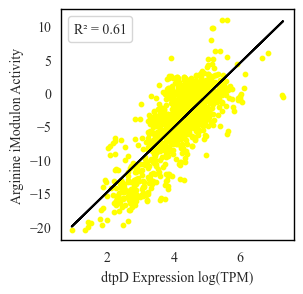

In [280]:
plot_scatter_with_fit(P1K_log_tpm, P1K_A, 'dtpD', 'Arginine', save_path = 'dtpD_expression_activity_corr.svg')

In [281]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_gene_correlation(X, gene1, gene2, save_path=None):
    # Extract the rows for the two genes
    x_values = X.loc[gene1].values.reshape(-1, 1)
    y_values = X.loc[gene2].values
    
    # Set custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    plt.figure(figsize=(3, 3))
    
    # Create scatter plot with smaller points and no label for the legend
    plt.scatter(x_values, y_values, s=10, color='yellow', label='_nolegend_')  # Custom color points

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(x_values, y_values)
    y_pred = model.predict(x_values)
    
    # Plot the line of best fit
    plt.plot(x_values, y_pred, color='black')

    # Calculate the R^2 value
    r2 = r2_score(y_values, y_pred)
    
    # Set font properties for ticks and labels
    plt.xlabel(f'{gene1} Expression log(TPM)', fontproperties=font_prop)
    plt.ylabel(f'{gene2} Expression log(TPM)', fontproperties=font_prop)
    
    # Set font properties for tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)

    # Remove the grid
    plt.grid(False)

    # Add a black box surrounding the plot with a width of 1
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(1)

    # Use superscript 2 character (²) instead of LaTeX math mode for R-squared
    r2_text = f'R² = {r2:.2f}'
    
    # Display the legend with the custom font and the manually formatted R-squared text
    legend = plt.legend([r2_text], handlelength=0, handletextpad=0, loc='best', prop=font_prop)

    # Save the plot to an SVG file if save_path is provided
    if save_path:
        plt.savefig(save_path, format='svg')

    # Show the plot
    plt.show()


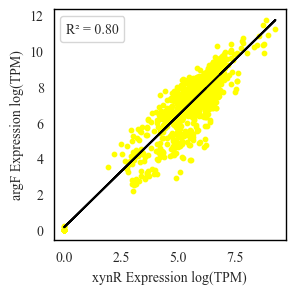

In [282]:
plot_gene_correlation(P1K_log_tpm, 'xynR', 'argF', save_path = 'xynR_expression_argF_corr.svg')

## Dual regulator example 1: astCADBE - ArgR/NtrC

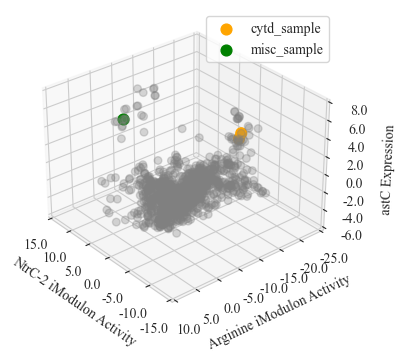

In [232]:
# 3D plot of NtrC, Arginine, and astC

# special samples
s1_cytd = ['p1k_00167','p1k_00168']
s2_misc = ['p1k_00049']

# data
ntrcA = precise1k.A.loc['NtrC-2'].tolist()
argA = precise1k.A.loc['Arginine'].tolist()
astC = precise1k.X.loc['b1748'].tolist()

# Import necessary modules
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.font_manager as fm

# Define the font path and create a FontProperties object
font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
font_prop = fm.FontProperties(fname=font_path)

# Create the figure and axis
fig = plt.figure(figsize=(4, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the main data points (plotted first to ensure other points are on top)
ax.scatter(ntrcA, argA, astC, alpha=0.3, color='gray', s=30)

# Scatter plot for special sample 1 (cytd_sample) - plotted on top
ax.scatter(precise1k.A.loc['NtrC-2'][s1_cytd].tolist(), 
           precise1k.A.loc['Arginine'][s1_cytd].tolist(), 
           precise1k.X.loc['b1748'][s1_cytd].tolist(), 
           alpha=1, color='orange', s=60, label='cytd_sample', zorder=2)

# Scatter plot for special sample 2 (misc_sample) - plotted on top
ax.scatter(precise1k.A.loc['NtrC-2'][s2_misc].tolist(), 
           precise1k.A.loc['Arginine'][s2_misc].tolist(), 
           precise1k.X.loc['b1748'][s2_misc].tolist(), 
           alpha=1, color='green', s=60, label='misc_sample', zorder=2)

# Set axis limits
ax.set_ylim([min(argA), 6])

# Set labels with custom font
ax.set_xlabel('NtrC-2 iModulon Activity', fontproperties=font_prop)
ax.set_ylabel('Arginine iModulon Activity', fontproperties=font_prop)
ax.set_zlabel('astC Expression', fontproperties=font_prop)

# Set custom tick locations to match the existing tick labels
xticks = ax.get_xticks()
yticks = ax.get_yticks()
zticks = ax.get_zticks()

# Set tick locations and apply the custom font
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_zticks(zticks)

ax.set_xticklabels(xticks, fontproperties=font_prop)
ax.set_yticklabels(yticks, fontproperties=font_prop)
ax.set_zticklabels(zticks, fontproperties=font_prop)

# Set the legend with custom font
ax.legend(prop=font_prop)

# Set the view angle for the 3D plot
ax.view_init(elev=30, azim=140)

# Save the figure as an SVG file
plt.savefig('3d_ArgR_activity_plot.svg', format='svg')

# Display the plot
plt.show()

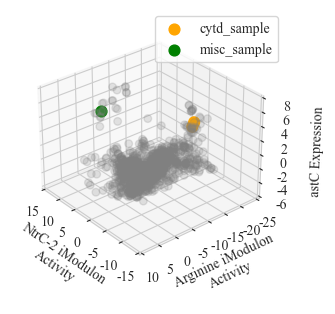

In [268]:
# Import necessary modules
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.font_manager as fm

# Define the font path and create a FontProperties object
font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
font_prop = fm.FontProperties(fname=font_path)

# Create the figure and axis with specified size
fig = plt.figure(figsize=(3.5, 7))  # Making the figure size taller (e.g., 4:12 ratio for more emphasis)
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the main data points (plotted first to ensure other points are on top)
ax.scatter(ntrcA, argA, astC, alpha=0.2, color='gray', s=30, zorder=1)  # Lower alpha for better visibility and zorder

# Scatter plot for special sample 1 (cytd_sample) - plotted on top
ax.scatter(precise1k.A.loc['NtrC-2'][s1_cytd].tolist(), 
           precise1k.A.loc['Arginine'][s1_cytd].tolist(), 
           precise1k.X.loc['b1748'][s1_cytd].tolist(), 
           alpha=1, color='orange', s=60, label='cytd_sample', zorder=3)  # Higher zorder to ensure on top

# Scatter plot for special sample 2 (misc_sample) - plotted on top
ax.scatter(precise1k.A.loc['NtrC-2'][s2_misc].tolist(), 
           precise1k.A.loc['Arginine'][s2_misc].tolist(), 
           precise1k.X.loc['b1748'][s2_misc].tolist(), 
           alpha=1, color='green', s=60, label='misc_sample', zorder=3)  # Higher zorder to ensure on top

# Set axis limits
ax.set_ylim([min(argA), 6])

# Set labels with custom font
ax.set_xlabel('NtrC-2 iModulon\nActivity', fontproperties=font_prop)
ax.set_ylabel('Arginine iModulon\nActivity', fontproperties=font_prop)
ax.set_zlabel('astC Expression', fontproperties=font_prop)

stretch_factor = 0.9  # Adjust this value to stretch the z-axis
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.9, 0.9, stretch_factor, 1]))

# Set custom tick locations to match the existing tick labels and convert them to integers
xticks = [int(x) for x in ax.get_xticks()]
yticks = [int(y) for y in ax.get_yticks()]
zticks = [int(z) for z in ax.get_zticks()]

# Set tick locations and apply the custom font
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_zticks(zticks)

ax.set_xticklabels(xticks, fontproperties=font_prop)
ax.set_yticklabels(yticks, fontproperties=font_prop)
ax.set_zticklabels(zticks, fontproperties=font_prop)

ax.tick_params(axis='x', pad=2)  # Adjust the padding value as needed
ax.tick_params(axis='y', pad=2)
ax.tick_params(axis='z', pad=2)

# Set the legend with custom font
ax.legend(prop=font_prop)

# Set the view angle for the 3D plot
ax.view_init(elev=30, azim=140)

# Save the figure as an SVG file
plt.savefig('3d_ArgR_activity_plot.svg', format='svg')

# Display the plot
plt.show()


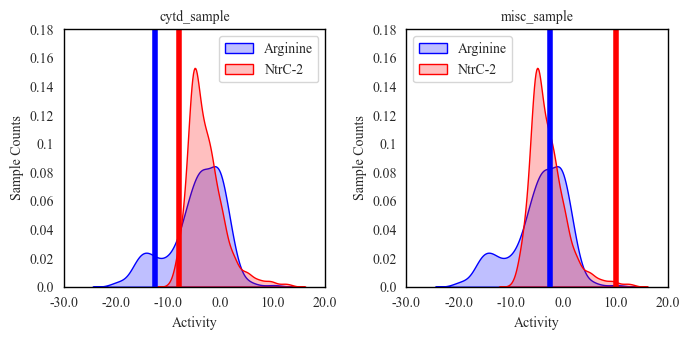

In [234]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Define the font path and create a FontProperties object
font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
font_prop = fm.FontProperties(fname=font_path)

samples = [['p1k_00167','p1k_00168'], 'p1k_00049']

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))  # 1 row, 2 columns

# Plot for Sample 1
sns.kdeplot(argA, color='blue', label='Arginine', ax=axs[0], fill=True)
sns.kdeplot(ntrcA, color='red', label='NtrC-2', ax=axs[0], fill=True)
axs[0].axvline(precise1k.A[samples[0]].loc['Arginine'].mean(), color='blue', linewidth=4)
axs[0].axvline(precise1k.A[samples[0]].loc['NtrC-2'].mean(), color='red', linewidth=4)
axs[0].set_xlabel("Activity", fontproperties=font_prop)
axs[0].set_ylabel("Sample Counts", fontproperties=font_prop)
axs[0].legend(prop=font_prop)
axs[0].set_title("cytd_sample", fontproperties=font_prop)

# Plot for Sample 2
sns.kdeplot(argA, color='blue', label='Arginine', ax=axs[1], fill=True)
sns.kdeplot(ntrcA, color='red', label='NtrC-2', ax=axs[1], fill=True)
axs[1].axvline(precise1k.A[samples[1]].loc['Arginine'], color='blue', linewidth=4)
axs[1].axvline(precise1k.A[samples[1]].loc['NtrC-2'], color='red', linewidth=4)
axs[1].set_xlabel("Activity", fontproperties=font_prop)
axs[1].set_ylabel("Sample Counts", fontproperties=font_prop)
axs[1].legend(prop=font_prop)
axs[1].set_title("misc_sample", fontproperties=font_prop)

# Remove grid and set black border for both subplots
for ax in axs:
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_color('black')  # Set the spine color to black
        spine.set_linewidth(1)     # Set the spine width to 1

    # Set tick locations and apply the custom font
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()

    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    ax.set_xticklabels(xticks, fontproperties=font_prop)
    ax.set_yticklabels(yticks, fontproperties=font_prop)

# Adjust layout and save to SVG
plt.tight_layout()
plt.savefig('cytd_misc_activities_distribution.svg', format='svg')

# Display the plot
plt.show()


## Bitome analysis of binding sites

Look at the binding site similarity in different parts of the argR regulon/iModulon
Does it support the idea that ICA works when the binding sites in the regulon have similar properties?


### Import data

In [69]:
K12_DATA_PATH = Path('../Data/mg1655')

In [70]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)

In [71]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    # TODO PARSE TTS data
    tts_table=None,
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

In [72]:
#ica_data = load_json_model('../data/precise2.json.gz')
ica_data = precise1k

## Motif score analysis

In [88]:
# modify legacy PSSM format into Bitome 2 format
tf_pwm_db = rpwm('../Data/motif_pwm_db.txt')
argR_pwm_old = tf_pwm_db['ArgR']
argR_pssm = {base: [pos_dict[base] for pos_dict in argR_pwm_old] for base in 'ATCG'}

argR_genes = ica_data.view_imodulon('Arginine')['gene_name'].values

gene2score = {}
for argR_gene in argR_genes:
    tus_for_gene = mg1655._gene_to_tus[ica_data.name2num(argR_gene)]
    gene_tu_df = mg1655.tu_table.loc[tus_for_gene]
    gene_tu_df_tss = gene_tu_df[gene_tu_df['tss'].notna()]
    scores = []
    for tu_id, tu_row in gene_tu_df_tss.iterrows():
        best_motif_match = mg1655.promoter_motif_search(tu_row.tss, tu_row.strand, argR_pssm)
        scores.append(best_motif_match.log_odds.values[0])
    if scores:
        gene2score[argR_gene] = np.mean(scores)
print(gene2score)

{'carA': 6.15, 'carB': 3.1666667, 'caiF': 2.0, 'argF': 11.3, 'artJ': 14.7, 'artM': 10.724999, 'artQ': 10.724999, 'artI': 10.724999, 'artP': 10.724999, 'hisP': 3.95, 'hisM': 3.95, 'hisQ': 3.95, 'hisJ': 3.95, 'argA': 7.3, 'argG': 15.7, 'argD': 8.6, 'asnA': 9.6, 'argE': 4.5499997, 'argC': 12.6, 'argB': 12.6, 'argH': 12.6, 'argI': 12.3}


<AxesSubplot:xlabel='argR Motif Log-Odds Score', ylabel='argR Gene Weight'>

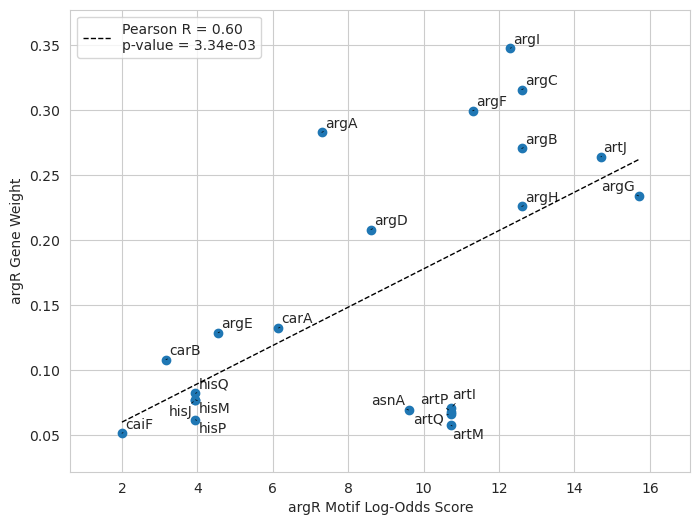

In [89]:
argR_df = ica_data.view_imodulon('Arginine')
argR_df['score'] = argR_df['gene_name'].apply(lambda gn: gene2score.get(gn, None))
argR_w_motif = argR_df[argR_df['score'].notna()]
argR_w_motif = argR_w_motif.set_index('gene_name')

_, ax = plt.subplots(figsize=(8, 6))

scatterplot(
    argR_w_motif['score'], argR_w_motif['gene_weight'],
    xlabel='argR Motif Log-Odds Score',
    ylabel='argR Gene Weight',
    show_labels=True,
    fit_line=True,
    legend=False,
    ax=ax
)

In [93]:
argR_w_motif

,gene_weight,synonyms,gene_product,COG,regulator,uniprot,start,end,strand,essential,core_genome,iML1515,oxidizeME,DGF_strain,MS57,pseudogene,y_ome,k_eff,schmidt_prot_med,heckmann_prot_med,proteomics,p1k,p1k_ctrl_log_tpm,p1k_median_log_tpm,p1k_mad_log_tpm,in_iM,score
gene_name,,,,,,,,,,,,,,,,,,,,,,,,,,,
carA,0.132216,carA;pyrA,carbamoyl phosphate synthetase subunit alpha,Nucleotide transport and metabolism,"RpoD,Fis,ArgR,PurR,PepA,RutR,IHF,ArcA",P0A6F1,29651,30799,+,False,False,True,True,True,True,False,False,True,4444.5,2154.0,True,True,10.215564,8.084122,1.941701,True,6.150000
carB,0.107868,carB;pyrA,carbamoyl phosphate synthetase subunit beta,Nucleotide transport and metabolism,"RpoD,Fis,ArgR,PurR,PepA,RutR,IHF",P00968,30817,34038,+,False,False,True,True,True,True,False,False,True,2238.5,2506.0,True,True,9.865358,7.672117,1.590878,True,3.166667
caiF,0.051293,caiF,DNA-binding transcriptional activator CaiF,Transcription,"RpoD,YdcN,H-NS,Fnr,Crp,NarL,Nac",P0AE58,34300,34695,+,False,False,False,False,True,True,False,False,False,NaN,NaN,False,True,5.725698,4.851363,1.313784,True,2.000000
argF,0.299276,argF,CP4-6 prophage%3B ornithine carbamoyltransfera...,Amino acid transport and metabolism,"RpoD,ArgR,ppGpp",P06960,289301,290305,-,False,False,True,True,False,False,False,False,True,41.0,381.0,True,True,8.896671,7.565149,1.222332,True,11.300000
artJ,0.263863,artJ,L-arginine ABC transporter periplasmic binding...,Amino acid transport and metabolism,"RpoD,ArgR",P30860,899844,900575,-,False,False,True,True,False,True,False,False,True,4351.5,3854.0,True,True,9.950698,8.929569,1.205336,True,14.700000
artM,0.057357,artM,L-arginine ABC transporter membrane subunit ArtM,Inorganic ion transport and metabolism,"RpoD,RpoS,ArgR,ppGpp",P0AE30,900866,901534,-,False,False,True,True,False,True,False,False,False,NaN,NaN,False,True,6.356242,6.312905,0.539044,True,10.724999
artQ,0.066203,artQ,L-arginine ABC transporter membrane subunit ArtQ,Inorganic ion transport and metabolism,"RpoD,RpoS,ArgR,ppGpp",P0AE34,901534,902250,-,False,False,True,True,False,True,False,False,True,NaN,140.0,True,True,6.328829,6.336608,0.565752,True,10.724999
artI,0.070494,artI,putative ABC transporter periplasmic binding p...,Amino acid transport and metabolism,"RpoD,RpoS,ArgR,Lrp",P30859,902257,902988,-,False,False,True,True,False,True,False,True,True,2145.0,970.0,True,True,8.134427,7.886871,0.654253,True,10.724999
artP,0.067930,artP,L-arginine ABC transporter ATP binding subunit,Inorganic ion transport and metabolism,"RpoD,RpoS,ArgR,Lrp",P0AAF6,903006,903734,-,False,False,True,True,False,True,False,False,True,574.0,323.0,True,True,7.587084,7.316250,0.717207,True,10.724999


In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.font_manager as fm
from adjustText import adjust_text

# Path to Times New Roman font
font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
font_prop = fm.FontProperties(fname=font_path)

def scatter_with_fit(score, gene_weight, gene_labels, xlabel, ylabel, save_as=None):
    # Create figure and scatter plot
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.scatter(score, gene_weight, color='blue')

    # Add labels for each point
    texts = []
    for i, label in enumerate(gene_labels):
        texts.append(ax.text(score[i], gene_weight[i], label, fontsize=10, fontproperties=font_prop))
    
    # Adjust text to prevent overlap, allowing more distance from points
    adjust_text(texts, 
                arrowprops=dict(arrowstyle="->", color='grey', lw=0.5), 
                expand_text=(1.5, 1.5),   # Increase text expansion from points
                expand_points=(2, 2),     # Increase space around points
                force_text=(0.5, 0.5),    # Slight repulsion of texts from each other
                force_points=(0.2, 0.2)   # Slight repulsion of texts from points
               )
    
    # Compute linear regression (fit line)
    slope, intercept, r_value, p_value, std_err = stats.linregress(score, gene_weight)
    
    # Generate a smooth line across the range of scores
    x_vals = np.linspace(min(score), max(score), 100)
    line = slope * x_vals + intercept
    
    # Plot the regression line with uniform dashed style
    ax.plot(x_vals, line, linestyle='--', color='black', dashes=(5, 5), label=f'Pearson R = {r_value:.2f}\np-value = {p_value:.2e}')
    
    # Add legend
    ax.legend(loc='upper left', prop=font_prop)

    # Set axis labels with custom font
    ax.set_xlabel(xlabel, fontproperties=font_prop)
    ax.set_ylabel(ylabel, fontproperties=font_prop)
    
    # Set tick labels with custom font
    ax.tick_params(axis='both', which='major', labelsize=10)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(font_prop)

    # Remove the grid
    ax.grid(False)
    
    # Add a black border around the plot
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    
    # Save plot as an SVG file if a path is provided
    if save_as:
        plt.savefig(save_as, format='svg', bbox_inches='tight')
    else:
        # Display the plot
        plt.show()

# Example usage:
# scatter_with_fit(argR_w_motif['score'], argR_w_motif['gene_weight'], argR_w_motif.index, 'argR Motif Log-Odds Score', 'argR Gene Weight', save_as='/path/to/save/plot.svg')


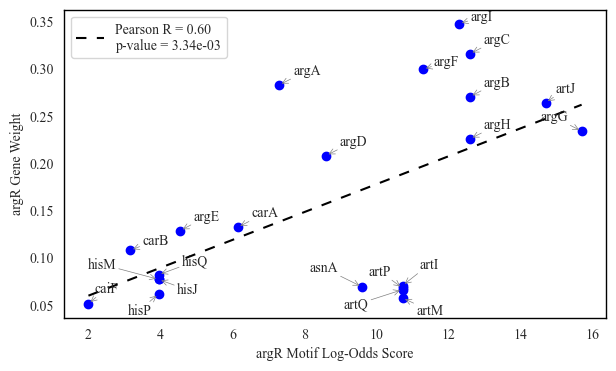

In [114]:
scatter_with_fit(argR_w_motif['score'], argR_w_motif['gene_weight'], argR_w_motif.index, 'argR Motif Log-Odds Score', 'argR Gene Weight', save_as = 'ArgR_Motif_Analysis.svg')

Can we find known ArgP binding sites according to RegulonDB? 28252 28271, and 28272 28291

In [78]:
# modify legacy PSSM format into Bitome 2 format
tf_pwm_db = rpwm('../data/motif_pwm_db.txt')
argR_pwm_old = tf_pwm_db['ArgR']
argR_pssm = {base: [pos_dict[base] for pos_dict in argR_pwm_old] for base in 'ATCG'}

In [79]:
mg1655.motif_search(28000, 29000, +1, argR_pssm, n_best_matches=5)

,match_sequence,log_odds,left,right
0,AGATCTGAAAGATTGCGCGGT,1.2,28925,28945
1,AAAAGAGAATAGCTATGCATG,-0.5,28360,28380
2,AAAGATGATTTTGATGTGTTT,-0.8,28581,28601
3,CATGATGCAAACATCCGCGTT,-0.9,28377,28397
4,GATATTGCGATTGTCTTTGCT,-1.0,28731,28751


Motif Matching near TSS

In [80]:
mg1655.promoter_motif_search(28288, 1, argR_pssm, n_best_matches=5)

,match_sequence,log_odds,left,right
0,GTTTATCATTAATTTCTAATT,-2.5,28272,28292
1,ATCATTAATTTCTAATTATCA,-3.2,28276,28296
2,TAATTTCTAATTATCAGCGTT,-3.4,28281,28301
3,TATCATTAATTTCTAATTATC,-3.4,28275,28295
4,ATTTCTAATTATCAGCGTTTT,-3.8,28283,28303


Getting Binding sites from the Bitome

In [81]:
bitome_tfbs_df = mg1655.tfbs_table[mg1655.tfbs_table['left'].notna()]
bitome_tfbs_df['source'] = 'RegulonDB'
bitome_tfbs_df.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,left,right,mode,final_state,tf,strand,source
locus_tag,,,,,,,
ECK120011181,612650.0,612668,repressor,Fur-Fe<sup>2+</sup>,Fur,NaN,RegulonDB
ECK120011181,612650.0,612668,repressor,Fur-Fe<sup>2+</sup>,Fur,NaN,RegulonDB
ECK120011184,4516744.0,4516762,repressor,Fur-Fe<sup>2+</sup>,Fur,NaN,RegulonDB
ECK120011188,1619005.0,1619019,activator,Fis,Fis,NaN,RegulonDB
ECK120011192,1619022.0,1619041,activator,Rob,Rob,NaN,RegulonDB


In [82]:
### Now looking at motifs of genes in iM vs Regulon

{'carA': 6.15, 'carB': 3.1666667, 'caiF': 2.0, 'argF': 11.3, 'artJ': 14.7, 'artM': 10.724999, 'artQ': 10.724999, 'artI': 10.724999, 'artP': 10.724999, 'hisP': 3.95, 'hisM': 3.95, 'hisQ': 3.95, 'hisJ': 3.95, 'argA': 7.3, 'argG': 15.7, 'argD': 8.6, 'asnA': 9.6, 'argE': 4.5499997, 'argC': 12.6, 'argB': 12.6, 'argH': 12.6, 'argI': 12.3}


<AxesSubplot:xlabel='argR Motif Log-Odds Score', ylabel='argR Gene Weight'>

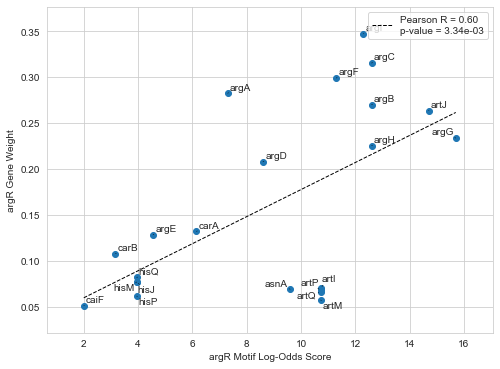

In [93]:
ArgR_iM_Genes
gene2score_iM = {}
for argR_gene in ArgR_iM_Genes:
    tus_for_gene = mg1655._gene_to_tus[ica_data.name2num(argR_gene)]
    gene_tu_df = mg1655.tu_table.loc[tus_for_gene]
    gene_tu_df_tss = gene_tu_df[gene_tu_df['tss'].notna()]
    scores = []
    for tu_id, tu_row in gene_tu_df_tss.iterrows():
        best_motif_match = mg1655.promoter_motif_search(tu_row.tss, tu_row.strand, argR_pssm)
        scores.append(best_motif_match.log_odds.values[0])
    if scores:
        gene2score_iM[argR_gene] = np.mean(scores)
print(gene2score_iM)

argR_df = ica_data.view_imodulon('Arginine')
argR_df['score'] = argR_df['gene_name'].apply(lambda gn: gene2score_iM.get(gn, None))
argR_w_motif = argR_df[argR_df['score'].notna()]
argR_w_motif = argR_w_motif.set_index('gene_name')

_, ax = plt.subplots(figsize=(8, 6))

scatterplot(
    argR_w_motif['score'], argR_w_motif['gene_weight'],
    xlabel='argR Motif Log-Odds Score',
    ylabel='argR Gene Weight',
    show_labels=True,
    fit_line=True,
    legend=False,
    ax=ax
)

In [109]:
ArgR_Regulon_Genes = Regulon_DB_TRN_filtered.index[Regulon_DB_TRN_filtered['ArgR']==1].to_list()
gene2score_Regulon = {}
for argR_gene in ArgR_Regulon_Genes:
    tus_for_gene = mg1655._gene_to_tus[ica_data.name2num(argR_gene)]
    gene_tu_df = mg1655.tu_table.loc[tus_for_gene]
    gene_tu_df_tss = gene_tu_df[gene_tu_df['tss'].notna()]
    scores = []
    for tu_id, tu_row in gene_tu_df_tss.iterrows():
        best_motif_match = mg1655.promoter_motif_search(tu_row.tss, tu_row.strand, argR_pssm)
        scores.append(best_motif_match.log_odds.values[0])
    if scores:
        gene2score_Regulon[argR_gene] = np.mean(scores)
print(gene2score_Regulon)

#Replace argR_df with the whole gene table - ica_data.gene_table then take just the regulon genes
argR_df = ica_data.gene_table.loc[ica_data.gene_table['gene_name'].isin(ArgR_Regulon_Genes)]  
argR_df['score'] = argR_df['gene_name'].apply(lambda gn: gene2score_Regulon.get(gn, None))
argR_w_motif = argR_df[argR_df['score'].notna()]
argR_w_motif = argR_w_motif.set_index('gene_name')
argR_df['score']


{'argA': 7.3, 'argB': 12.6, 'argC': 12.6, 'argD': 8.6, 'argE': 4.5499997, 'argF': 11.3, 'argG': 15.7, 'argH': 12.6, 'argI': 12.3, 'argR': 7.2, 'aroK': 3.4, 'aroP': -1.4, 'artI': 10.724999, 'artJ': 14.7, 'artM': 10.724999, 'artP': 10.724999, 'artQ': 10.724999, 'astA': 1.1, 'astB': 1.1, 'astC': 1.1, 'astD': 1.1, 'astE': 1.1, 'carA': 6.15, 'carB': 3.1666667, 'cvpA': -0.2, 'dacC': 5.1, 'dps': -0.1, 'ftsZ': -1.47, 'gltB': 2.7, 'gltD': 2.7, 'gltF': 2.7, 'hchA': 0.19999999, 'hisJ': 3.95, 'hisM': 3.95, 'hisP': 3.95, 'hisQ': 3.95, 'infB': 0.46666667, 'lrp': 3.8, 'lysO': 8.5, 'mukE': -0.6, 'nusA': 1.02, 'pfkB': 4.6, 'pnp': 3.35, 'potF': 9.55, 'puuB': 4.5499997, 'rbfA': 3.85, 'rimP': 2.25, 'rpsO': 2.925, 'stpA': 3.0, 'truB': 3.85, 'waaA': 0.13333333, 'yaaU': -1.1}



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


b0032     6.150000
b0033     3.166667
b0045    -1.100000
b0095    -1.470000
b0112    -1.400000
           ...    
b3959    12.600000
b3960    12.600000
b4077          NaN
b4246          NaN
b4254    12.300000
Name: score, Length: 61, dtype: float64

In [113]:
ArgR_Intersect = list(set(ArgR_iM_Genes) & set(ArgR_Regulon_Genes))
ArgR_iMOnly_Genes = list(set(ArgR_iM_Genes).symmetric_difference(ArgR_Intersect))
print(ArgR_iMOnly_Genes)

['xynR', 'caiF', 'asnA', 'dtpD']


In [114]:
ArgR_RegulonOnly_Genes = list(set(ArgR_Regulon_Genes).symmetric_difference(ArgR_Intersect))
print(ArgR_RegulonOnly_Genes)

['aroK', 'hchA', 'gltB', 'astB', 'astA', 'truB', 'astD', 'infB', 'cvpA', 'yraQ', 'ftsZ', 'nusA', 'argR', 'dacC', 'ydgI', 'yfcC', 'yhcC', 'ykgA', 'lysO', 'pyrL', 'astC', 'dps', 'yaaU', 'stpA', 'rpsO', 'gltP', 'gltD', 'potF', 'yffB', 'puuB', 'gltF', 'eutS', 'pnp', 'rbfA', 'mukE', 'aroP', 'lrp', 'astE', 'rimP', 'pfkB', 'waaA']
